In [70]:
import numpy as np

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x)) # logsig

def sigmoid_prime(x):
    return sigmoid(x)*(1.0-sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1.0 - x**2

def lin(x):
    return x


class NeuralNetwork:

    def __init__(self, layers, activation='tanh'):
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_prime = sigmoid_prime
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_prime = tanh_prime

        # Set weights
        self.weights = []
        # layers = [2,2,1]
        # range of weight values (-1,1)
        # input and hidden layers - random((2+1, 2+1)) : 3 x 3
        for i in range(1, len(layers) - 1):
            r = 2*np.random.random((layers[i-1] + 1, layers[i] + 1)) -1
            self.weights.append(r)
        # output layer - random((2+1, 1)) : 3 x 1
        r = 2*np.random.random( (layers[i] + 1, layers[i+1])) - 1
        self.weights.append(r)

    # fits the network using backpropagation algorthm
    def fit(self, X, y, learning_rate=0.2, epochs=100000):
        # Add column of ones to X
        # This is to add the bias unit to the input layer
        ones = np.atleast_2d(np.ones(X.shape[0]))
        X = np.concatenate((ones.T, X), axis=1)
         
        for k in range(epochs):
            #if k % 10000 == 0: print('epochs:', k)
            
            i = np.random.randint(X.shape[0])
            a = [X[i]]

            for l in range(len(self.weights)):
                    dot_value = np.dot(a[l], self.weights[l])
                    activation = self.activation(dot_value)
                    a.append(activation)
            # output layer
            error = y[i] - a[-1]
            deltas = [error * self.activation_prime(a[-1])]

            # we need to begin at the second to last layer 
            # (a layer before the output layer)
            for l in range(len(a) - 2, 0, -1): 
                deltas.append(deltas[-1].dot(self.weights[l].T)*self.activation_prime(a[l]))

            # reverse
            # [level3(output)->level2(hidden)]  => [level2(hidden)->level3(output)]
            deltas.reverse()

            # backpropagation
            # 1. Multiply its output delta and input activation 
            #    to get the gradient of the weight.
            # 2. Subtract a ratio (percentage) of the gradient from the weight.
            for i in range(len(self.weights)):
                layer = np.atleast_2d(a[i])
                delta = np.atleast_2d(deltas[i])
                self.weights[i] += learning_rate * layer.T.dot(delta)
        
        return self.weights

    def predict(self, x): 
        a = np.concatenate((np.ones(1).T, np.array(x)), axis=0)      
        for l in range(0, len(self.weights)):
            a = self.activation(np.dot(a, self.weights[l]))
        return a
    
#     def predict(self, x):
#         x = np.array(x)
#         temp = np.ones(x.shape[0]+1)
#         temp[0:-1] = x
#         a = temp
#         for l in range(0, len(self.weights)):
#             a = self.activation(np.dot(a, self.weights[l]))
#         return a



In [71]:
# Some basic constants...
LETTERS = 25
MAX_WORD_LENGHT = 5
CHAR_BITS = 5 # Enough for 25 letters
#input_size = MAX_WORD_LENGHT * (len(bin(LETTERS))-2)

In [72]:
def transform_word(word):
    word = word.lower()
    bin_word = ''.join([bin(ord(x)-ord('a'))[2:].zfill(CHAR_BITS) for x in word])
    bin_word = bin_word + "1" * CHAR_BITS * (MAX_WORD_LENGHT - len(word))
    return list(map(int, bin_word))

def encode_unary(index, total_words):
    zeros = [0] * total_words
    zeros[index] = 1
    return zeros

In [73]:
f = "table.txt"
with open (f, "r") as file:
    raw_data = file.read().strip().split()

data = []
for word in raw_data:
    if (len(word) <= MAX_WORD_LENGHT and word not in data):
        data.append(word.lower())

table = [(transform_word(data[index]), encode_unary(index, len(data)), data[index]) for index in range(len(data))]
output_size = len(table)
print(table)


[([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0], [1, 0, 0, 0], 'lorem'), ([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0], [0, 1, 0, 0], 'ipsum'), ([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 1, 0], 'es'), ([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 1], 'et')]


In [74]:
input_size = MAX_WORD_LENGHT * CHAR_BITS
hidden_sizes = [10]
layers = [input_size] + hidden_sizes + [output_size]

In [75]:
def generate_words(set_size, good_word_prob):
    X = np.array([table[0][0]])
    y = np.array([table[0][1]])
    for _ in range(set_size - 1):
        if np.random.uniform(0, 1) < good_word_prob:
            index = np.random.randint(len(table))
            X = np.concatenate((X, [table[index][0]]))
            y = np.concatenate((y, [table[index][1]]))
        else:
            found = False
            while not found:
                found = True
                bad_word = [np.random.randint(2) for _ in range(input_size)]
                for i in range(len(table)):
                    if (table[i][0] == bad_word):
                        found = False
                        break
                if found:
                    X = np.concatenate((X, [bad_word]))
                    y = np.concatenate((y, [[0] * output_size]))
    return X, y

In [76]:
train_x, train_y = generate_words(set_size=20000, good_word_prob=0.6)
#test_x, test_y = generate_words(set_size=1000, good_word_prob=0.7)

In [77]:
f = "data.txt"
with open (f, "r") as file:
    raw_data = file.read().strip().split()

escape_chars = [".", ",", "!", "?", ";"]
    
data = []
for word in raw_data:
    if (len(word) <= MAX_WORD_LENGHT):
        w = word
        for i in range(len(escape_chars)):
            w = w.replace(escape_chars[i], "")

        if (w.isalpha):
            data.append(w.lower())
        

test_x = np.array([transform_word(w) for w in data])
test_y = np.array([[0] * len(table) for _ in range(len(test_x))])
test_z = np.array(data)

for i in range(len(test_x)):
    for j in range(len(table)):
        if (np.array_equal(table[j][0], test_x[i])):
            test_y[i] = table[j][1]



In [78]:
net = NeuralNetwork(layers, activation='tanh')
_ = net.fit(train_x, train_y, epochs=100000)
print("Fit complete")

Fit complete


In [79]:
def pretty_print(x, y, predicted_y):
    print(x, y, [float("%.3f" % value) for value in predicted_y])

# success of the net using MSE
def success(test_x, test_y):
    MSE = 0
    for (x, y) in zip(test_x, test_y):
        prediction = net.predict(x)
        MSE += sum((prediction - y) ** 2)
    return 1 - (MSE / (len(test_x) * output_size))
    
show_max = 10
count = 0
for (x, y) in zip(test_x, test_y):
    pretty_print(x, y, net.predict(x))
    count += 1
    if (show_max == count):
        break
    

s = success(test_x, test_y)
print("Succ: ", s)
print("Err:  ", 1 - s)


[0 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0] [1 0 0 0] [0.994, 0.002, 0.001, 0.001]
[0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 0 0 1 1 0 0] [0 1 0 0] [-0.009, 0.993, -0.004, -0.006]
[0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 0 0 0 1] [0 0 0 0] [-0.003, 0.008, 0.005, 0.007]
[1 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1] [0 0 0 0] [-0.005, 0.004, 0.003, 0.003]
[0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1] [0 0 0 0] [-0.007, -0.003, -0.006, -0.002]
[0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1] [0 0 0 0] [-0.007, -0.002, -0.003, 0.012]
[1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1] [0 0 0 0] [-0.003, 0.009, 0.005, 0.005]
[1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1] [0 0 0 0] [-0.003, 0.008, 0.004, 0.006]
[0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0] [0 0 0 0] [-0.001, 0.009, 0.004, 0.006]
[0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1] [0 0 0 0] [-0.006, 0.001, -0.001, 0.001]
Succ:  0.983514950313
Err:   0.0164850496873


In [80]:
from sklearn import neural_network as nn
clf = nn.MLPClassifier(hidden_layer_sizes=(16, ),
                       activation='tanh',
                       solver='adam',
                       alpha=0.00001,
                       verbose=True,
                       tol=0.001,
                       learning_rate='constant',
                       learning_rate_init=0.001)

model = clf.fit(train_x, train_y)
predictions = model.predict_proba(test_x)

print("Loss function: ", model.loss)
#print("Loss value: ", model.loss_)
print("Score: ", model.score(test_x, test_y)) # score = mean accuracy on given data set


Iteration 1, loss = 2.10851759
Iteration 2, loss = 1.25250804
Iteration 3, loss = 0.90546120
Iteration 4, loss = 0.69440444
Iteration 5, loss = 0.55545223
Iteration 6, loss = 0.45174019
Iteration 7, loss = 0.37099704
Iteration 8, loss = 0.30632446
Iteration 9, loss = 0.25423577
Iteration 10, loss = 0.21274537
Iteration 11, loss = 0.17966537
Iteration 12, loss = 0.15338897
Iteration 13, loss = 0.13227074
Iteration 14, loss = 0.11513214
Iteration 15, loss = 0.10108758
Iteration 16, loss = 0.08942400
Iteration 17, loss = 0.07965300
Iteration 18, loss = 0.07144361
Iteration 19, loss = 0.06444960
Iteration 20, loss = 0.05837427
Iteration 21, loss = 0.05314652
Iteration 22, loss = 0.04860173
Iteration 23, loss = 0.04462304
Iteration 24, loss = 0.04108157
Iteration 25, loss = 0.03796897
Iteration 26, loss = 0.03516881
Iteration 27, loss = 0.03266050
Iteration 28, loss = 0.03041298
Iteration 29, loss = 0.02835693
Iteration 30, loss = 0.02652368
Iteration 31, loss = 0.02481730
Iteration 32, los

In [81]:
tolerance = 0.2

def round_prediction(y):
    result = []
    for i in range(len(y)):
        if (y[i] - tolerance <= 0):
            result.append(0)
        elif (y[i] + tolerance >= 1):
            result.append(1)
        else:
            return np.zeros(len(y))
    return result
    
rounded_predictions = np.copy(predictions)

# Round predictions based on tolerance:
for i in range(len(predictions)):
    rounded_predictions[i] = round_prediction(predictions[i])


In [82]:
print(" WORD  ->  PREDICTED (first 20 words)")
print("=====================================")

mistakes = []

printed = 0
for i in range(len(test_x)):
    if not np.array_equal(rounded_predictions[i], test_y[i]):
        for j in range(len(table)):
            predicted_word = ""
            if (np.array_equal(table[j][1], rounded_predictions[i])):
                predicted_word = table[j][2]
                break
        #print(test_y[i], predictions[i])
        print(test_z[i].rjust(MAX_WORD_LENGHT), " -> ", predicted_word, "   (", test_y[i], [float("%.3f" % value) for value in predictions[i]], ")")
        printed += 1
    if (printed >= 20):
        break

 WORD  ->  PREDICTED (first 20 words)
  est  ->  es    ( [0 0 0 0] [0.001, 0.0, 0.967, 0.014] )
   ad  ->  et    ( [0 0 0 0] [0.0, 0.002, 0.002, 0.955] )
   ac  ->  es    ( [0 0 0 0] [0.001, 0.0, 0.975, 0.006] )
   ad  ->  et    ( [0 0 0 0] [0.0, 0.002, 0.002, 0.955] )
   ea  ->  es    ( [0 0 0 0] [0.0, 0.0, 0.959, 0.009] )
   ac  ->  es    ( [0 0 0 0] [0.001, 0.0, 0.975, 0.006] )
   ac  ->  es    ( [0 0 0 0] [0.001, 0.0, 0.975, 0.006] )
   at  ->  et    ( [0 0 0 0] [0.0, 0.002, 0.004, 0.976] )
  est  ->  es    ( [0 0 0 0] [0.001, 0.0, 0.967, 0.014] )
  est  ->  es    ( [0 0 0 0] [0.001, 0.0, 0.967, 0.014] )
   at  ->  et    ( [0 0 0 0] [0.0, 0.002, 0.004, 0.976] )
  est  ->  es    ( [0 0 0 0] [0.001, 0.0, 0.967, 0.014] )
   at  ->  et    ( [0 0 0 0] [0.0, 0.002, 0.004, 0.976] )
   at  ->  et    ( [0 0 0 0] [0.0, 0.002, 0.004, 0.976] )
   ab  ->  et    ( [0 0 0 0] [0.0, 0.003, 0.001, 0.928] )
   at  ->  et    ( [0 0 0 0] [0.0, 0.002, 0.004, 0.976] )
   ad  ->  et    ( [0 0 0 0] [0.0, 0

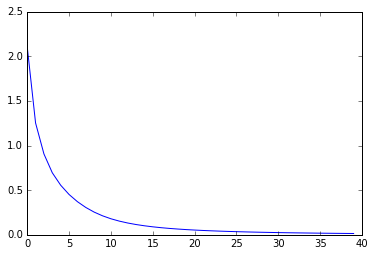

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(model.loss_curve_)
plt.show()

In [84]:
print("Test")

Test
